## Facial Expression Recognition

This exercise is aimed at building a Convolutional Neural Network (CNN) that recognizes facial expressions namely: angry, sad, fear, happy, neutral, disgust

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.7.0


In [2]:
path = r"C:\Users\user\Documents\Data Analytics\facial expressions 2\train"
test = r"C:\Users\user\Documents\Data Analytics\facial expressions 2\test"
for expression in os.listdir(path):
    new = os.path.join(path,expression)
    print(str(len(os.listdir(new))) + " " + expression + " images")

153 angry images
147 disgust images
150 fear images
155 happy images
157 neutral images
157 sad images
157 surprise images


In [3]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory(path,
                                target_size = (img_size, img_size),
                                color_mode = "grayscale",
                                batch_size = batch_size,
                                class_mode = 'categorical',
                                shuffle = True)
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(test,
                                      target_size =(img_size,img_size),
                                      color_mode = "grayscale",
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      shuffle=False)

Found 1076 images belonging to 7 classes.
Found 539 images belonging to 7 classes.


In [29]:
# Initializing the CNN
model = Sequential()

#1st Convolution Layer
model.add(Conv2D(64, (3,3), padding = 'same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) #prevents overfitting

# 2nd Convolution Layer
model.add(Conv2D(128, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd Convolution Layer
model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten()) #converts the data into a 1 dimensional array

# Fully connected 1st Layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_24 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_25 (Bat  (None, 24, 24, 128)     

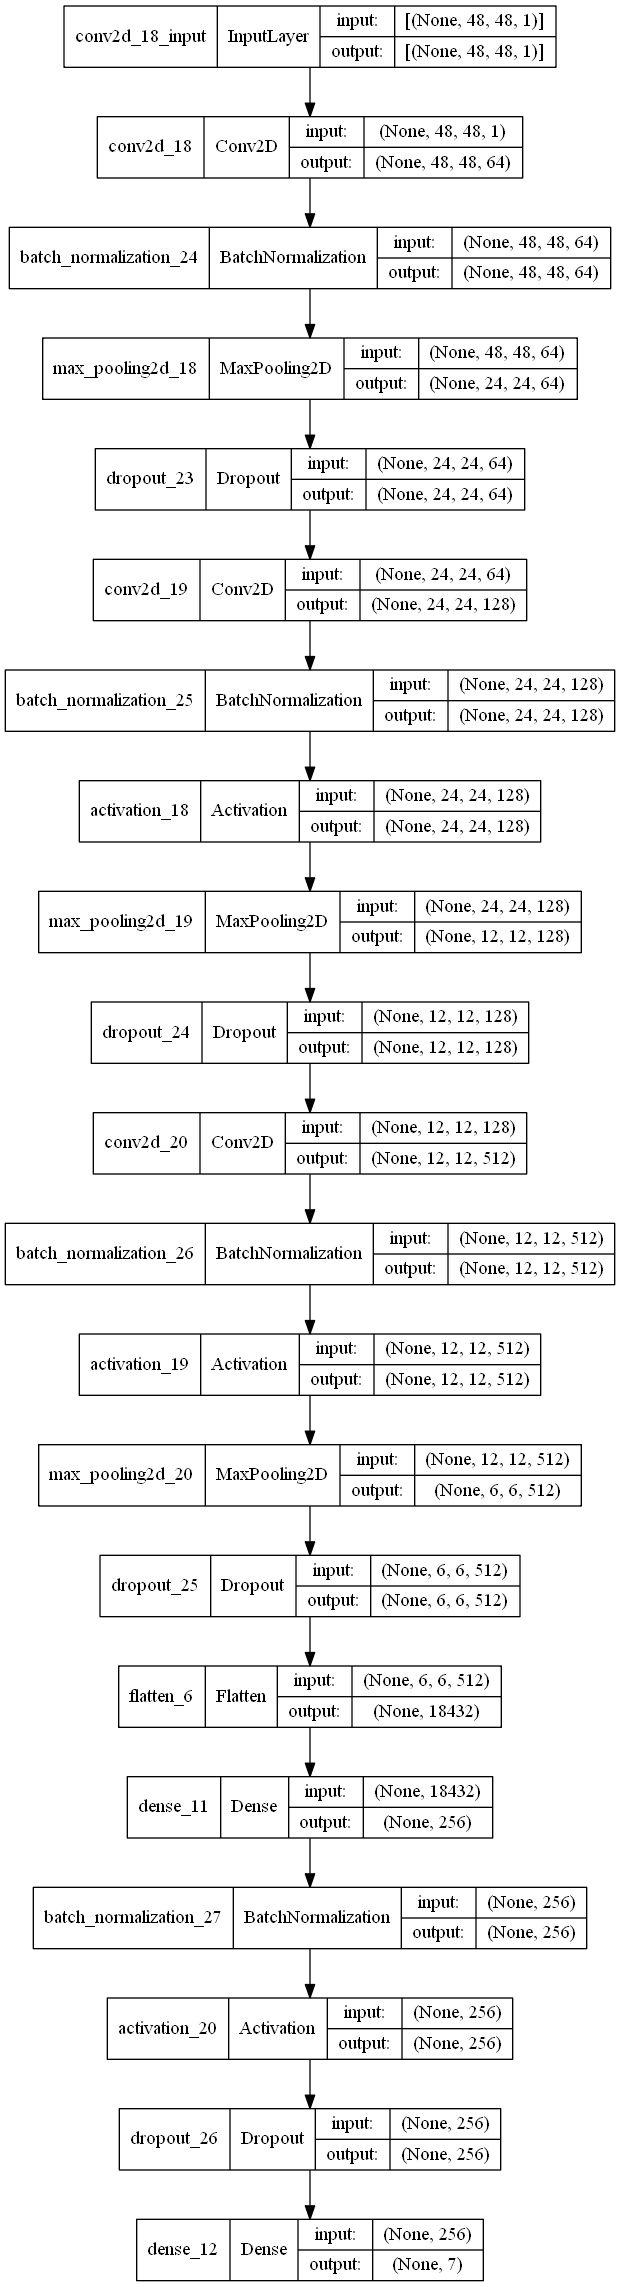

In [30]:
plot_model(model, to_file='model.png', show_shapes=True,
          show_layer_names=True)
Image('model.png', width=400, height=200)

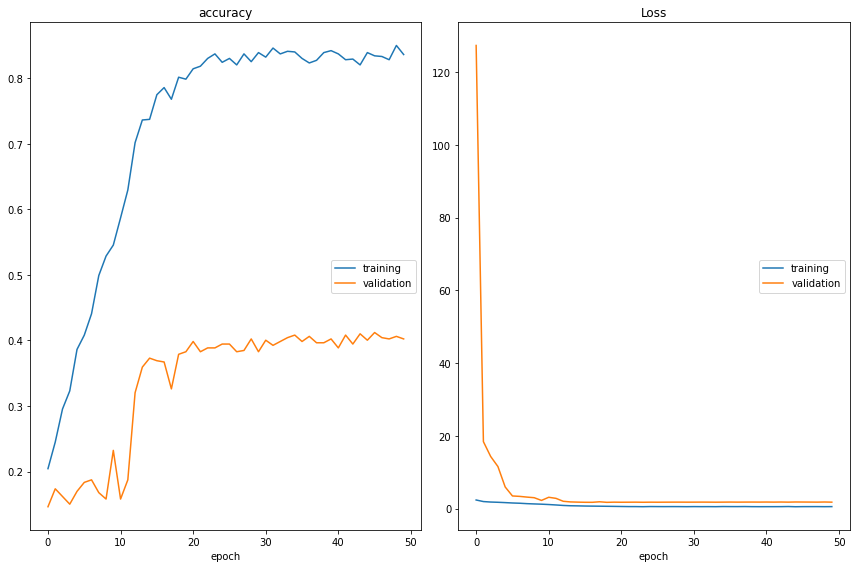

accuracy
	training         	 (min:    0.205, max:    0.850, cur:    0.836)
	validation       	 (min:    0.146, max:    0.412, cur:    0.402)
Loss
	training         	 (min:    0.532, max:    2.385, cur:    0.567)
	validation       	 (min:    1.741, max:  127.306, cur:    1.789)

Epoch 00050: saving model to model2_weights.h5
16/16 [==============================] - 38s 2s/step - loss: 0.5668 - accuracy: 0.8360 - val_loss: 1.7888 - val_accuracy: 0.4023 - lr: 1.0000e-05
Wall time: 30min 34s


In [31]:
%%time

epochs = 50
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                             patience=2, min_lr= 0.00001, mode='auto')
checkpoint = ModelCheckpoint("model2_weights.h5", monitor='val_accuracy',
                            save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(x=train_generator, steps_per_epoch=steps_per_epoch,
                   epochs = epochs, validation_data = validation_generator,
                   validation_steps = validation_steps, callbacks=callbacks)

In [32]:
model2_json = model.to_json()
model.save_weights('model2_weights.h5')
with open("model2.json", "w") as json2_file:
    json2_file.write(model2_json)

In [4]:
from tensorflow.keras.models import model_from_json

class FacialExpressionModel(object):
    
    EMOTIONS_LIST = ["Angry", "Disgust",
                    "Fear", "Happy", "Neutral",
                    "Sad", "Suprise"]
    
    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json2_file:
            loaded_model_json = json2_file.read()
            self.loaded_model = model_from_json(loaded_model_json)
        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()
        
    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]

In [11]:
import cv2

facec = cv2.CascadeClassifier(r'C:\Users\user\anaconda3\cv2\data\haarcascade_frontalface_default.xml')
model = FacialExpressionModel("model2.json","model2_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX

class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture(r"C:\Users\user\Documents\Data Analytics\Video.mp4")
    
    def __del__(self):
        self.video.release()
        
    #returns camera frames along with bounding boxes and predictions
    def get_frame(self):
        _, fr = self.video.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)
        
        for (x,y,w,h) in faces:
            fc = gray_fr[y:y+h, x:x+w]
            
            roi = cv2.resize(fc, (48,48))
            pred = model.predict_emotion(roi[np.newaxis, :, :,
                                            np.newaxis])
            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr, (x,y), (x+w, y+h), (255,0,0),2)
        return fr

In [12]:
def gen(camera):
    while True:
        frame = camera.get_frame()
        cv2.imshow('Facial Expression Recognization', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

In [13]:
gen(VideoCamera())

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
